

Data source AURIN

* ABS - data by region - population & people 2011-2017
* ABS - data by region - income (including government allowances) (LGA) 2011 - 2017

### Loading data

In [1]:
import numpy as np
import pandas as pd


df = pd.read_csv("./income_data.csv")

cols = [" lga_code17" , ' lga_name17' , ' equiv_tot_hsld_inc_fam_lone_p_grp_hslds_med_wkly_aud', ' est_p_inc_med_tot_inc_excl_gov_pnsn_aud']

sub_df = df[cols]

sub_df = sub_df.rename(columns={" lga_code17":"lga_code17",' lga_name17':'lga_name17',
                                ' equiv_tot_hsld_inc_fam_lone_p_grp_hslds_med_wkly_aud':"household_income" ,
                      ' est_p_inc_med_tot_inc_excl_gov_pnsn_aud':"personal_income"})

population_df = pd.read_csv("./population_data.csv")

cols = [" lga_code17" , " lga_name17" , ' pop_density_pop_density_p_p_km2',' est_res_pop_p_tot_num' , ' est_res_pop_p_wrking_age_pop_15_64_yrs_pr100']

pop_sub_df = population_df[cols]

pop_sub_df = pop_sub_df.rename(columns={" lga_code17":"lga_code17",' lga_name17':'lga_name17',
    ' pop_density_pop_density_p_p_km2':"population_density" ,
                                       ' est_res_pop_p_tot_num':"population",
                                      ' est_res_pop_p_wrking_age_pop_15_64_yrs_pr100':"working_age_population" })



join_df = pd.merge(pop_sub_df , sub_df , on=["lga_code17", "lga_name17"])






### Low income area : personal income within the buttom 40%.

### High income area : personal income within the top 20%.

In [2]:

def is_in_income_rage(income,income_range):
    
    R = list(join_df['personal_income'].quantile(income_range))
    
    return income >= R[0] and income <= R[1]




tmp_df = join_df
tmp_df['low_income'] = tmp_df['personal_income'].map(lambda income: is_in_income_rage(income , [0,0.40]))
tmp_df['high_income'] = tmp_df['personal_income'].map(lambda income: is_in_income_rage(income , [0.80,1.0]))

In [3]:
print("Income range in buttom 40% {}".format(list(join_df['personal_income'].quantile([0,0.40]))))
print("Income range in top 20% {}".format(list(join_df['personal_income'].quantile([0.80,1]))))

Income range in buttom 40% [20329.0, 42426.2]
Income range in top 20% [51732.4, 100665.0]


In [4]:


tmp_df[tmp_df.low_income == True].sort_values(by=['population'] , ascending=False).head()

,lga_code17,lga_name17,population_density,population,working_age_population,household_income,personal_income,low_income,high_income
254,36720,Sunshine Coast (R),134.4,302841,61.9,785,41566.0,True,False
76,12380,Cumberland (A),3154.3,225691,68.6,736,40890.0,True,False
80,12850,Fairfield (C),2026.2,205675,67.4,630,42326.0,True,False
191,22670,Greater Dandenong (C),1236.8,160222,67.9,659,39845.0,True,False
263,33220,Fraser Coast (R),14.5,102962,57.2,585,38664.0,True,False


In [5]:

# list of lga_code of interest.
codes = [57910 , 17200 ,37010,21110,16550,22310,89399,25060,26350,18500,56580,25900,
        71000,27350,14170 , 15350,15950 , 14500,14700,22670,16950,11800,14850,33220,17550,
        31820,11730,12380,36720,11300,61610,34580,20740,12750,22830,24780,10250,18050,22110,
         22830,16380,35740
        ]

sub_df = tmp_df[tmp_df.lga_code17.isin(codes)]

In [6]:
sub_df.head()

,lga_code17,lga_name17,population_density,population,working_age_population,household_income,personal_income,low_income,high_income
2,10250,Ballina (A),88.7,42993,58.7,745,39782.0,True,False
18,14170,Inner West (A),5405.3,191194,72.6,1315,59101.0,False,True
23,14500,Ku-ring-gai (A),1433.9,122472,61.9,1512,58598.0,False,True
27,14700,Lane Cove (A),3597.0,37694,68.1,1578,67210.0,False,True
29,14850,Lismore (C),34.3,44122,64.1,683,40074.0,True,False


In [7]:
import couchdb
db_tweet_name = 'new_twitter_search'
db_user = 'user_ids'
db_user_name = 'admin'
db_password = "admin"

db_address = "http://%s:%s@172.26.38.116:5984/" % (db_user_name, db_password)
db_server = couchdb.Server(db_address)
db_tweet = db_server[db_tweet_name]

data_negative_sentiment = {}

for item in db_tweet.view("_design/application/_view/location_count_negative",group=True):
#     print(item.key,item.value)
    data_negative_sentiment[item.key] = item.value


data_total = {}

for item in db_tweet.view('_design/application/_view/location_count_all',group=True):
#     print(item.key,item.value)
    data_total[item.key] = item.value



In [8]:
sub_df['new_name']=sub_df.lga_name17.apply(lambda x:x.rsplit(" ",1)[0].lower().replace(" ",'_'))

sub_df.new_name[464] = 'ACT'

df1 = pd.DataFrame(data_total.values(),data_total.keys(),columns=['Total_count'])
df1['name'] = data_total.keys()
df2 = pd.DataFrame(data_negative_sentiment.values() , data_negative_sentiment.keys(),columns=['Negative_count'])
df2['name'] = data_negative_sentiment.keys()
df3 = df1.merge(df2 , left_on='name',right_on='name')

df3.name[4]='burwood'
df3.name[19] = 'port_macquarie-hastings'
df3.name[5]='cumberland'
df3.name[13] =  'ku-ring-gai'
df3.head()


/Users/ethanchen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/ethanchen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ethanchen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

,Total_count,name,Negative_count
0,14179,ACT,2485
1,21939,ballina,3519
2,30633,bass_coast,5815
3,39800,boroondara,7079
4,86118,burwood,13785


In [9]:
sub_df.head()

,lga_code17,lga_name17,population_density,population,working_age_population,household_income,personal_income,low_income,high_income,new_name
2,10250,Ballina (A),88.7,42993,58.7,745,39782.0,True,False,ballina
18,14170,Inner West (A),5405.3,191194,72.6,1315,59101.0,False,True,inner_west
23,14500,Ku-ring-gai (A),1433.9,122472,61.9,1512,58598.0,False,True,ku-ring-gai
27,14700,Lane Cove (A),3597.0,37694,68.1,1578,67210.0,False,True,lane_cove
29,14850,Lismore (C),34.3,44122,64.1,683,40074.0,True,False,lismore


In [10]:
df4 = sub_df.merge(df3 , left_on='new_name',right_on='name')
df4['percetange_negative'] = df4.Negative_count/df4.Total_count

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,10]
plt.rcParams['figure.dpi'] = 110

(array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ]),
 <a list of 9 Text xticklabel objects>)

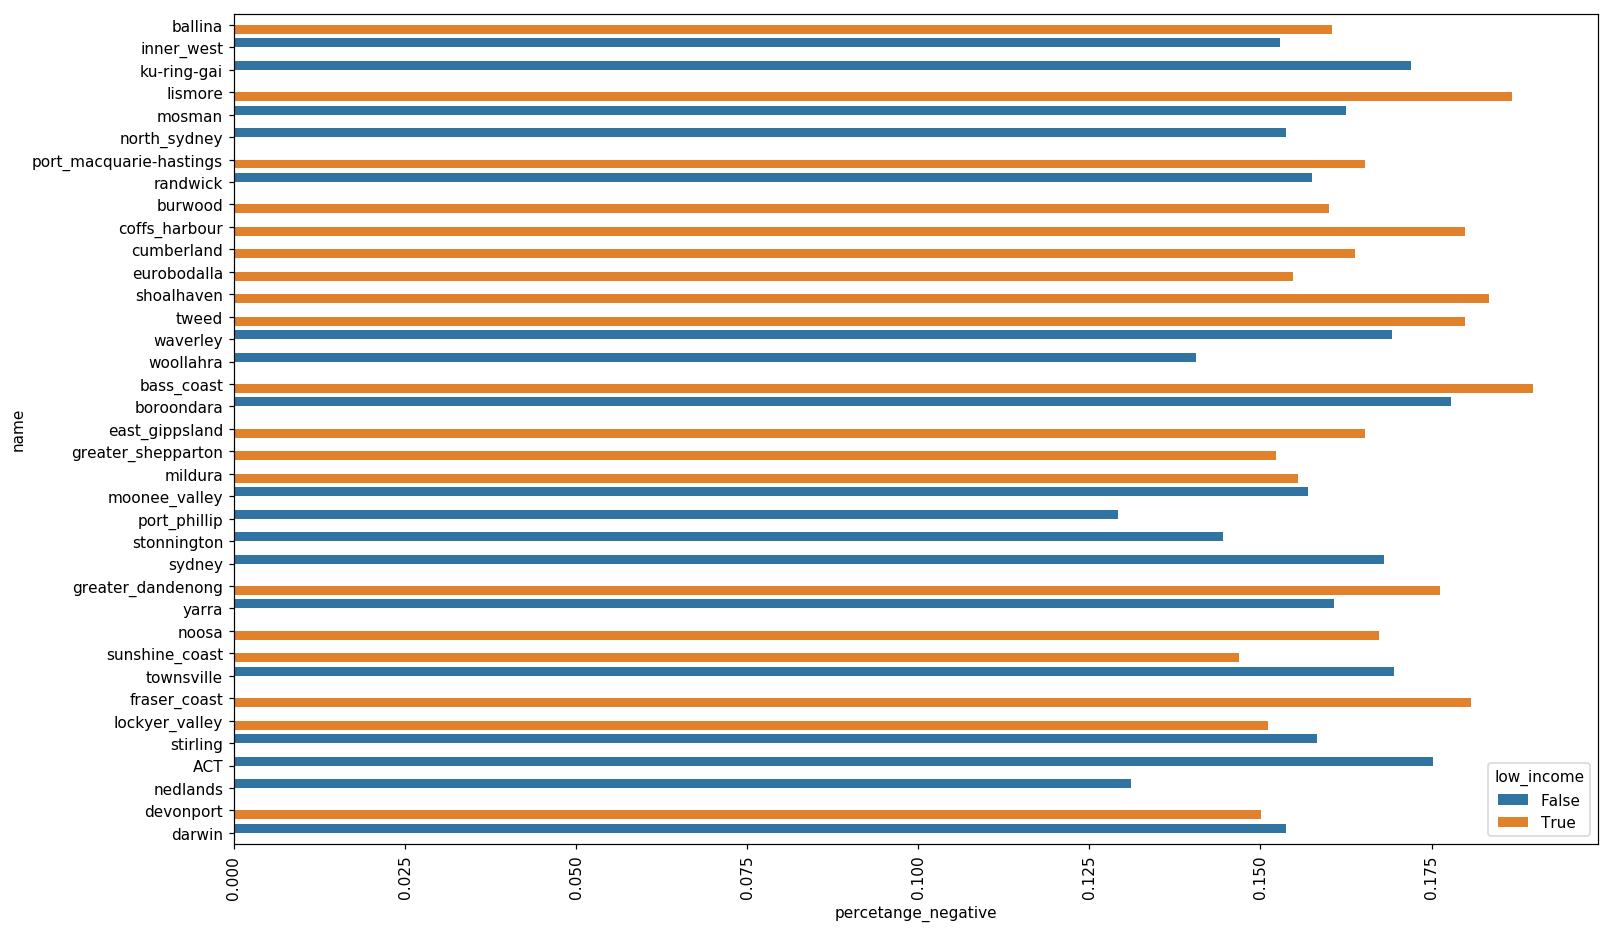

In [17]:


ax = sns.barplot(x="percetange_negative", y='name',hue='low_income', data=df4)
plt.xticks(rotation=90)

/Users/ethanchen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/ethanchen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


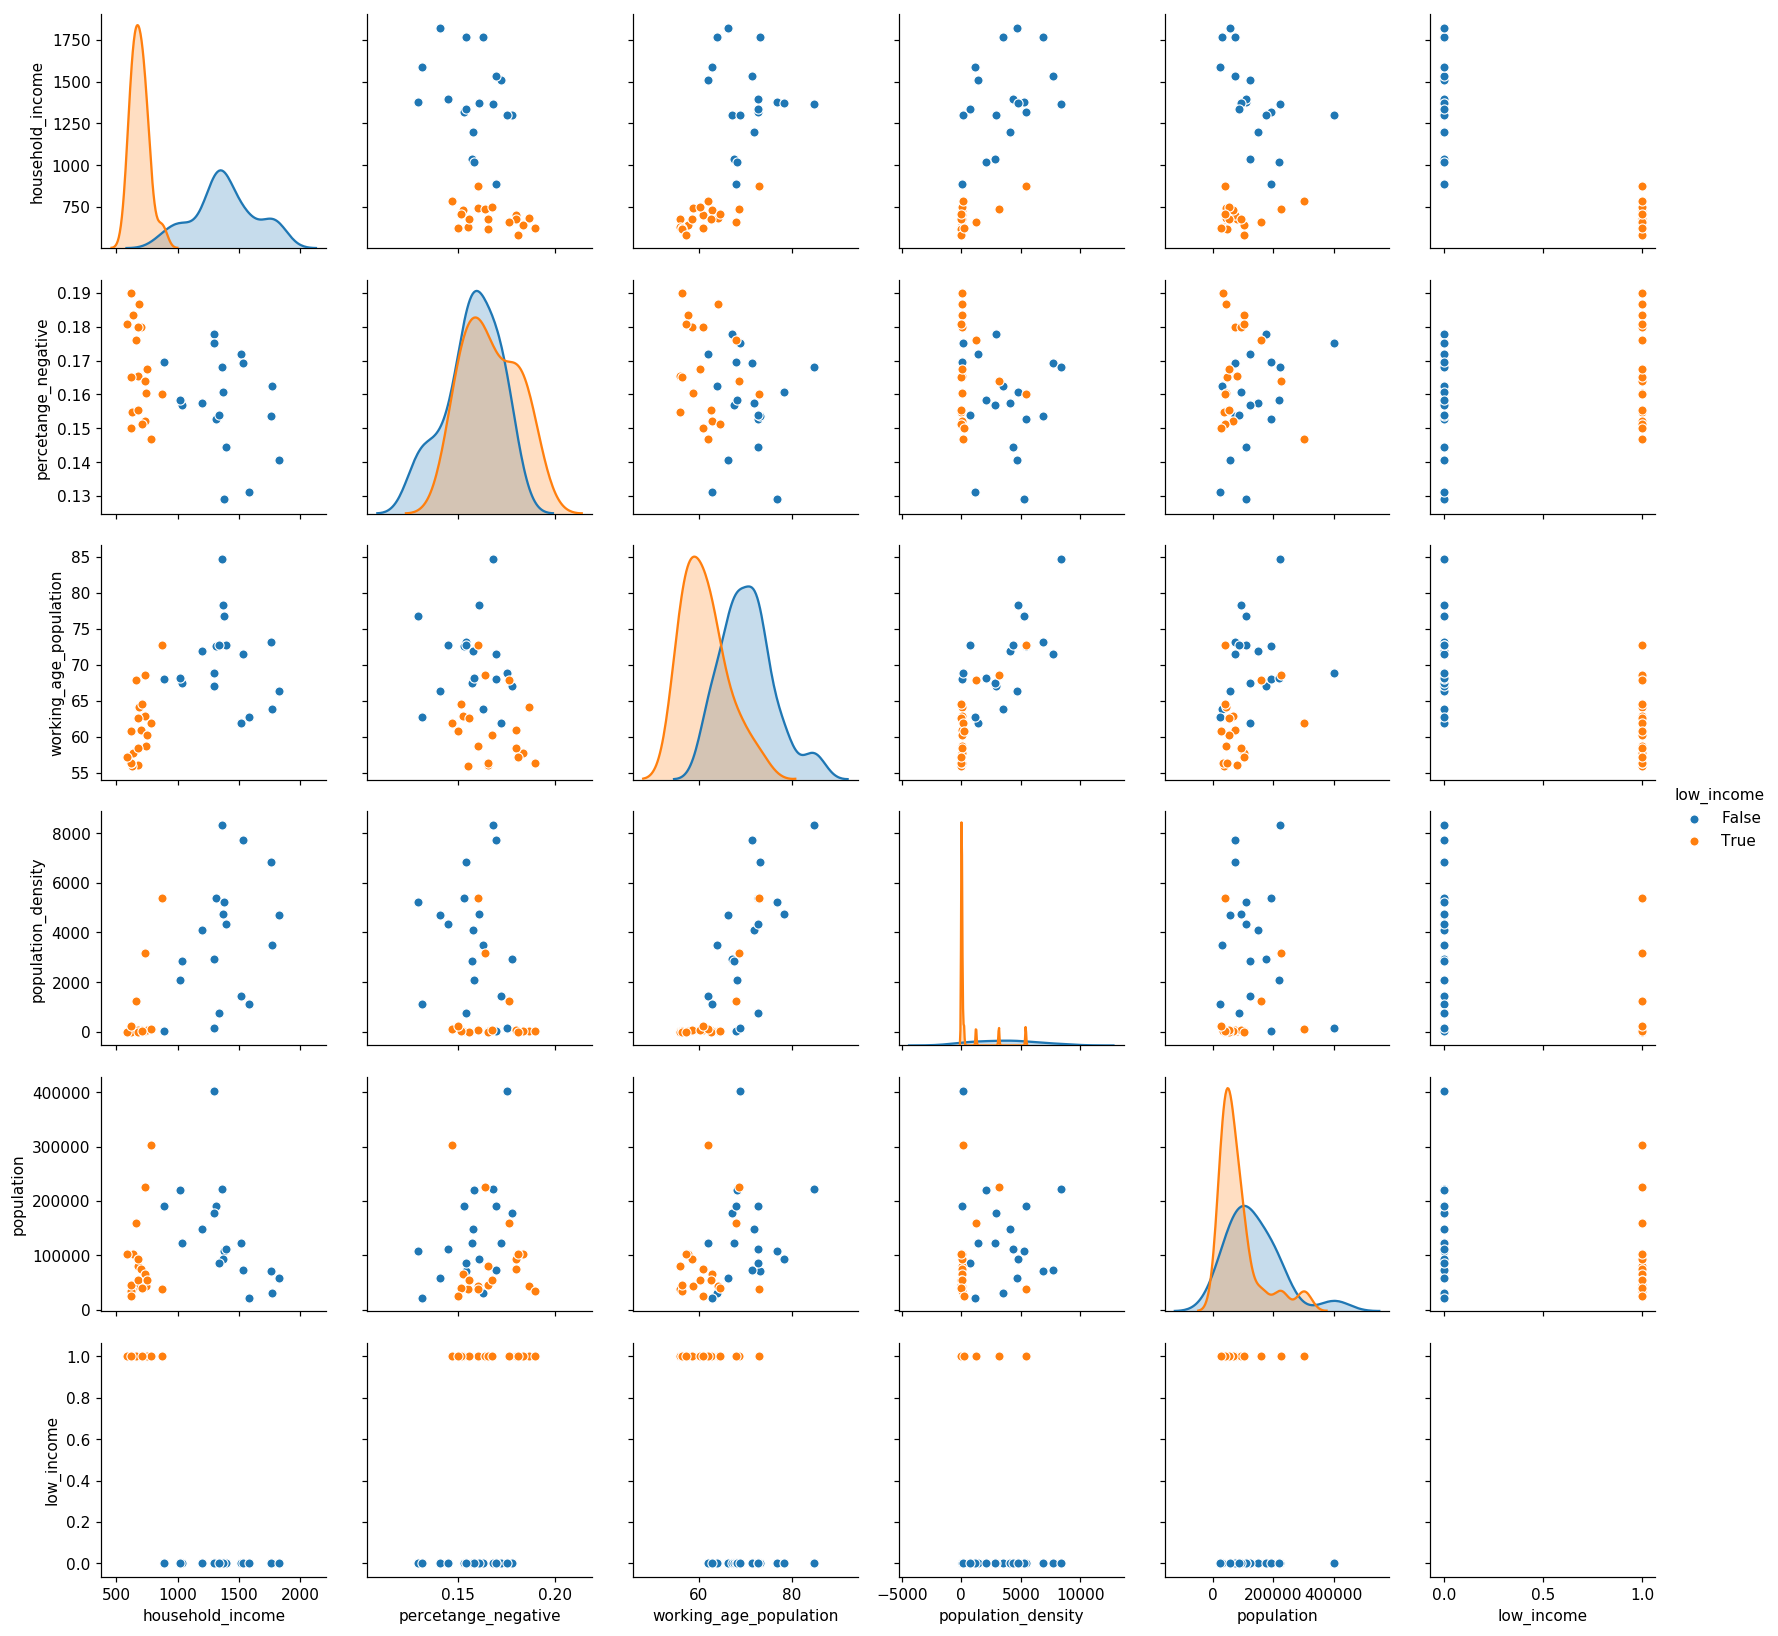

In [21]:


df4_sub = df4[['household_income','percetange_negative',
               'working_age_population','population_density','population',"low_income"]]

g = sns.pairplot(df4_sub ,hue="low_income")

plt.savefig("plot1.png")

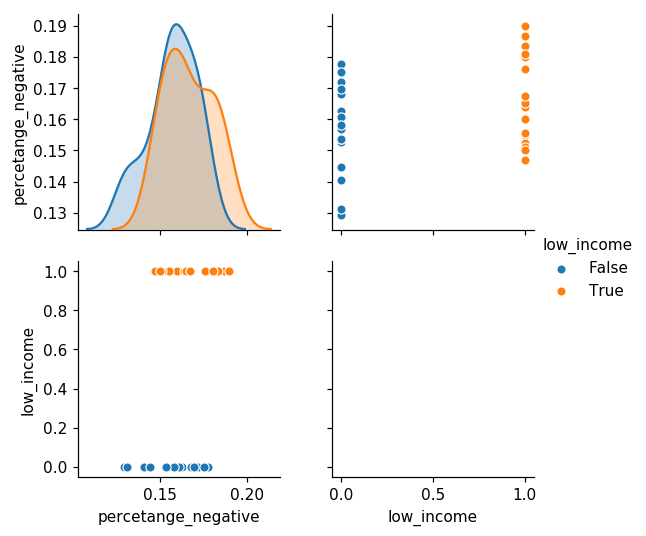

In [19]:
g = sns.pairplot(df4_sub[['percetange_negative','low_income']] ,hue="low_income")

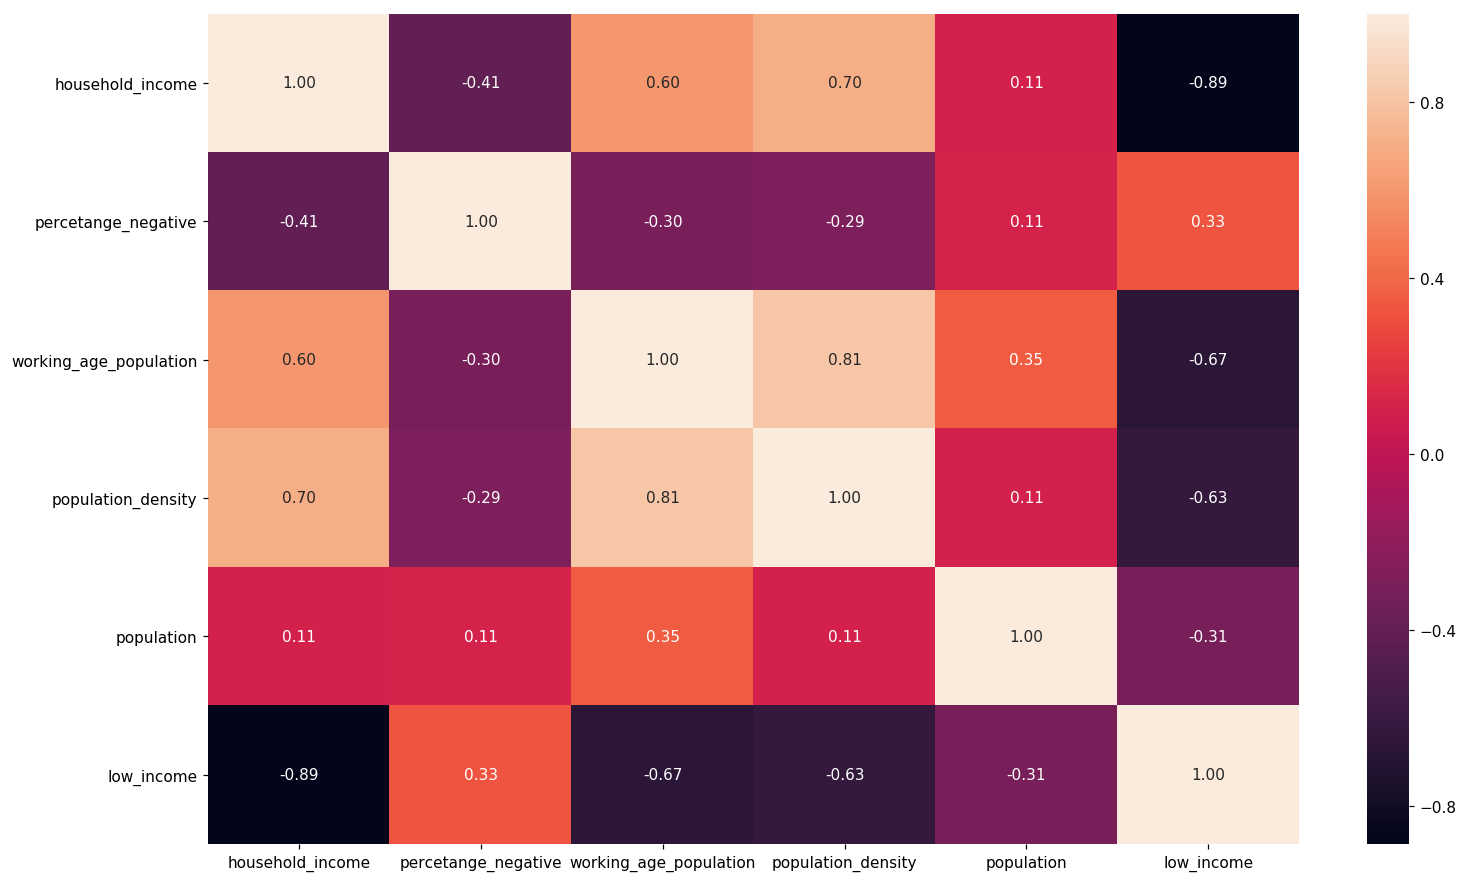

In [20]:
sns.heatmap(df4_sub.corr(), annot=True, fmt=".2f")